In [1]:
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import geopy.distance
from matplotlib import cm
from io import StringIO
import json

from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.interpolate import interp1d


In [2]:

# right, need to convert lat/lon to euclidean
origin_x = -106.544256
origin_y = 35.034674
foot_x = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_x *= 0.9
    else:
        foot_x *= 1.05
        
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
foot_y = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_y *= 0.9
    else:
        foot_y *= 1.05
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
    

def ll2euclid(ptx, pty):
    pt = np.array([ptx, pty])
    pt -= [origin_y, origin_x]
    pt /= [foot_y, foot_x]
    return pt    

In [3]:
def trip2function(trip):
    # first, make sure the trip info is in order
    lats = trip.latitude.to_numpy()
    lons = trip.longitude.to_numpy()
    times = [ str2time(t) for t in trip.msg_time]
    msg_order = np.argsort(times)
    lats = lats[msg_order]
    lons = lons[msg_order]
    cumdist = [0]
    for i,(lat2,lon2) in enumerate(zip(lats, lons)):
        if i > 0:
            cumdist.append( cumdist[-1] + geopy.distance.geodesic([lat1,lon1], [lat2,lon2]).feet)
        lat1,lon1 = lat2,lon2
    cumdist = np.array(cumdist) / cumdist[-1]
    lat_interp = interp1d(cumdist, lats)
    lon_interp = interp1d(cumdist, lons)
    return lambda t: np.array([lat_interp(t), lon_interp(t)])


def autocluster(data, return_order=False, return_linkage=False, plot=False, **kwargs):
    ag = AgglomerativeClustering(distance_threshold=0,n_clusters=None,**kwargs)
    ag.fit(data)
    linkage_matrix, order = plot_dendrogram(ag)
    idx = len(linkage_matrix) - elbow(list(enumerate(linkage_matrix[:,2])))
    if plot:
        plt.plot(linkage_matrix[:,2][::-1])
        plt.show()
    print("number of clusters: ", idx)
    ag2 = AgglomerativeClustering(n_clusters=idx, **kwargs)
    ag2.fit(data)
    ret = [ag2]
    if return_order:
        ret.append(order)
    if return_linkage:
        ret.append(linkage_matrix)
    return tuple(ret) if len(ret) > 1 else ret[0]

def elbow(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx    

def plot_dendrogram(model, plot=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    order = dendrogram(linkage_matrix, no_plot = not plot, get_leaves=True, **kwargs)['leaves']
    return linkage_matrix, order

In [4]:

def str2time(s):
    hour,minute,second = list(map(int,s.split(':')))
    return second + 60*minute + 60*60*hour


with open('stoplocations.json') as file:
    stoplocations = json.load(file)
    
with open('stopnames.json') as file:
    stopnames = json.load(file)    


In [24]:
all_lengths = []
def filter_trips(arts):
    print(f"initial {len(arts)}")
    eb_allstops = {}
    for art in tqdm(arts):
        for stop in set(art.next_stop_id.tolist()):
            eb_allstops[stop] = eb_allstops.get(stop, 0) + 1
    eb_allstops = [ s for s,c in eb_allstops.items() if c > len(arts)/2]
    
    truncated_arts = []
    start_lats = []
    start_lngs = []
    end_lats = []
    end_lngs = []
    for art in tqdm(arts, desc="finding start/end"):
        row = np.argmin(list(map(str2time, art.msg_time)))
        start_lats.append(art.iloc[row].latitude)
        start_lngs.append(art.iloc[row].longitude)
        row = np.argmax(list(map(str2time, art.msg_time)))
        end_lats.append(art.iloc[row].latitude)
        end_lngs.append(art.iloc[row].longitude)
    start_lat = np.median(start_lats)
    start_lng = np.median(start_lngs)
    end_lat = np.median(end_lats)
    end_lng = np.median(end_lngs)
    
    start = ll2euclid(start_lat, start_lng)
    end = ll2euclid(end_lat, end_lng)
    
    for art in tqdm(arts, desc="truncating"):
        start_row = np.argmin([np.linalg.norm(start - ll2euclid(lat,lng)) for lat,lng in zip(art.latitude, art.longitude)])
        end_row = np.argmin([np.linalg.norm(end - ll2euclid(lat,lng)) for lat,lng in zip(art.latitude, art.longitude)])
        if start_row < end_row:
            truncated_arts.append(art.iloc[start_row:end_row])
    arts = truncated_arts
    priority = np.zeros((len(eb_allstops), len(eb_allstops)))
    print(f"now {len(arts)}")
        
    for art in tqdm(arts):
        order = uniq(art.next_stop_id.tolist())
        order = [o for o in order if o in eb_allstops]
        for i,s1 in enumerate(order):
            idx1 = eb_allstops.index(s1)
            for s2 in order[i+1:]:
                idx2 = eb_allstops.index(s2)
    #             assert idx1 != idx2
                priority[idx1,idx2] += 1
    counter = np.zeros(priority.shape)
    for art in tqdm(arts):
        order = uniq(art.next_stop_id.tolist())
        order = [o for o in order if o in eb_allstops]
        for i,s1 in enumerate(order):
            idx1 = eb_allstops.index(s1)
            for s2 in order:
                idx2 = eb_allstops.index(s2)
    #             assert idx1 != idx2
                counter[idx1,idx2] += 1
    priority = priority / counter    

    eb_order = np.argsort(np.linalg.norm(priority, axis=0, ord=1))
    eb_stops = [eb_allstops[i] for i in eb_order ]

    # now I know the stop order
    valid_arts = []
    # include only buses that come within 500 feet of each stop, in order
    stop_euclid_locs = [ ll2euclid(stoplocations[s]['lat'], stoplocations[s]['lng']) for s in eb_stops]
    errs = []
    for art in tqdm(arts, desc='filtering'):
        locs = np.array([ll2euclid(row.latitude, row.longitude) for _,row in art.iterrows()])
        errors = 0
        for stop in stop_euclid_locs:
            distances = np.linalg.norm(locs - stop, axis=1)
            stop_idx = np.argmin(distances)
            all_lengths.append(distances[stop_idx])
            if distances[stop_idx] > 700:
                break
            locs = locs[stop_idx:]
        else:
            valid_arts.append(art)
            errs.append(errors)
    print(f"now {len(valid_arts)}")
    plt.plot(sorted(errs))
    plt.title("missed stops")
    plt.show()
    # breakpoint()
    lengths = [ sum([np.linalg.norm(ll2euclid(art.latitude.iloc[i], art.longitude.iloc[i]) - ll2euclid(art.latitude.iloc[i-1], art.longitude.iloc[i-1])) for i in range(1,len(art))]) for art in valid_arts]
    slengths = sorted(lengths)
    idx = elbow(list(enumerate(slengths)))
    plt.plot(sorted(lengths))
#     med_length = np.median(lengths)
#     buffer = med_length - min(lengths)
    length_limit = slengths[idx]
    print()
    plt.plot([0,len(lengths)],[length_limit, length_limit])
    plt.show()
    valid_arts = [art for leng, art in zip(lengths, valid_arts) if leng <= length_limit]
    # now all the trips start from the same spot, and end in the same spot, and have similar lengths, so we can just cluster them
#     trips = [trip2function(art) for art in valid_arts]
#     tripl2 = np.zeros((len(trips),len(trips)))
#     for i,t in enumerate(tqdm(trips, desc="clustering trips")):
#         for j,t2 in enumerate(trips[i+1:]):
#             tripl2[i,i+j] = np.linalg.norm(t(np.linspace(0,1,1000)) - t2(np.linspace(0,1,1000)))
#             tripl2[i+j,i] = tripl2[i,i+j]
#     ag = autocluster(tripl2, metric="precomputed", linkage='complete', plot=True)
#     cluster_sizes = [0]*ag.n_clusters_
#     for l in ag.labels_:
#         cluster_sizes[l] += 1
#     big_cluster = np.argmax(cluster_sizes)
#     valid_arts = [art for l, art in zip(ag.labels_, valid_arts) if l == big_cluster]
                      
    print(f"now {len(valid_arts)}")
    return valid_arts, eb_stops

def uniq(li):
    output = [li[0]]
    for l in li[1:]:
        if l not in output:
            output.append(l)
    return output

In [6]:
line_id = 777
line_id = str(line_id)
full_days = '10_11 10_10 10_8 10_9 9_28 9_23 9_21 9_22 9_12 10_7 9_19 9_16 9_17 9_18'.split()
all_arts = []
for day in tqdm(full_days, desc='Loading data'):
    with zipfile.ZipFile('../busdata/bus.zip') as file:
        with file.open(f'bus_data_2022_{day}.csv') as myfile:
            data = myfile.read()


    df = pd.read_csv(StringIO(data.decode()))
    arts = df[df.route_short_name==line_id]
    for id in set(arts.trip_id):
        all_arts.append(arts[arts.trip_id == id]) 
        all_arts[-1] = all_arts[-1].sort_values('msg_time', key=lambda x: [str2time(y) for y in x])


Loading data: 100%|████████████████████████████████████████████████████████████████████| 14/14 [00:44<00:00,  3.15s/it]


100%|███████████████████████████████████████████████████████████████████████████| 1450/1450 [00:00<00:00, 25052.17it/s]


East/West
512  eastbound
938  westbound
initial 512


truncating: 100%|████████████████████████████████████████████████████████████████████| 512/512 [00:09<00:00, 52.66it/s]


now 511


filtering: 100%|█████████████████████████████████████████████████████████████████████| 511/511 [00:17<00:00, 29.81it/s]


now 273


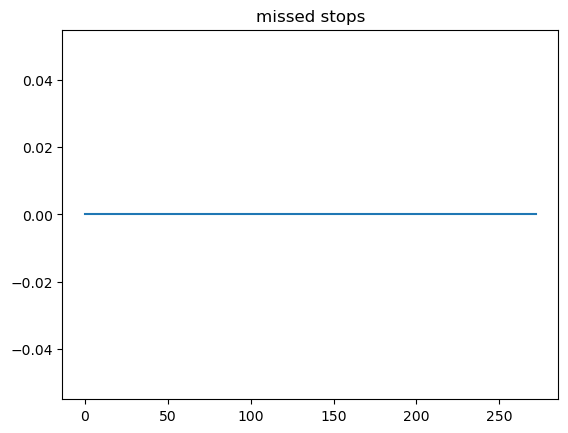

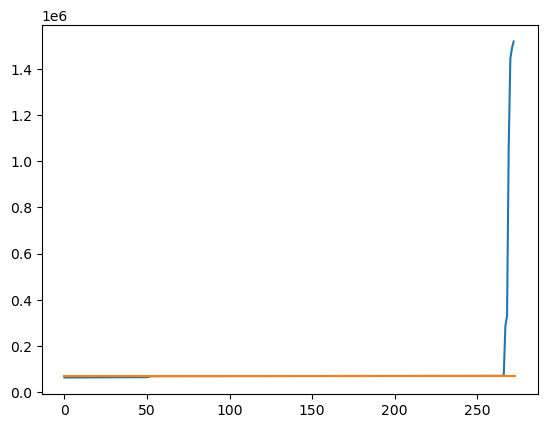

now 267
initial 938


truncating: 100%|████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 62.15it/s]


now 889


filtering: 100%|█████████████████████████████████████████████████████████████████████| 889/889 [00:20<00:00, 42.54it/s]


now 505


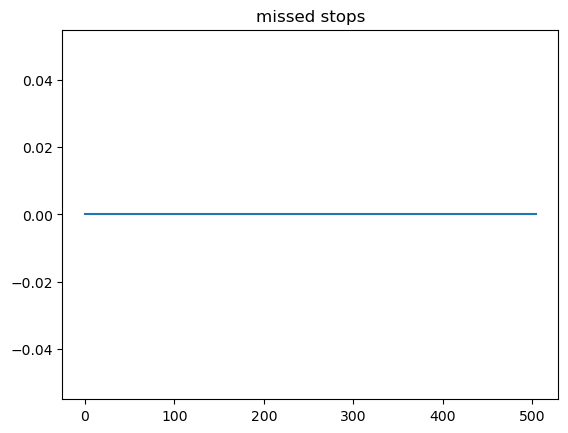

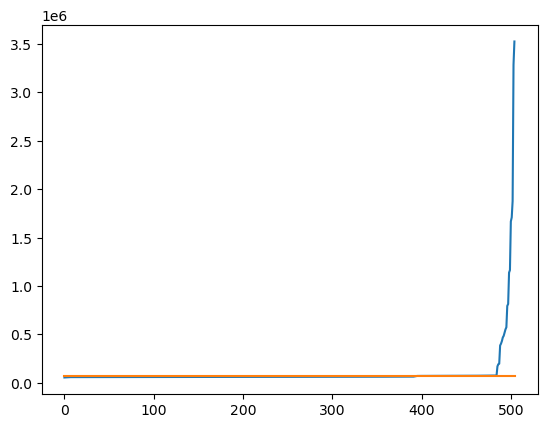

now 485
267  eastbound
485  westbound


In [25]:


# plt.imshow(dist_mat[order][:,order])
# plt.show()    

# filter by how close they are to real stops
with open('stoplookup.json') as file:
    tripstops = json.load(file)
# tripstops
# filter by how close they are to real stops
real_artstop_locations = [ stoplocations[s] for s,v in tqdm(tripstops.items()) if int(line_id) in v]
real_artstop_locations

allstops = set()
for art in tqdm(all_arts):
    allstops = allstops.union(art.next_stop_id.tolist())
allstops = list(allstops)
allstop_locations = np.array([ll2euclid(stoplocations[i]['lat'], stoplocations[i]['lng']) for i in allstops if i in stoplocations]) # N x 2

_,_,vt = np.linalg.svd(allstop_locations - np.mean(allstop_locations, axis=0), full_matrices=False)
principal_axis = vt[0]

if abs(principal_axis[0]) > abs(principal_axis[1]):
    print('North/South') # positive is northbound
    directions = 'north south'.split()
    principal_axis /= principal_axis[0]
else:
    print('East/West') # positive is eastbound
    directions = 'east west'.split()
    principal_axis /= principal_axis[1]
# ok, now we do a different analysis: counterfactuals
all_arts_eb = [art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable') for art in all_arts if (ll2euclid(art.iloc[-1].latitude, art.iloc[-1].longitude) - ll2euclid(art.iloc[0].latitude, art.iloc[0].longitude))@principal_axis > 0 ]
all_arts_wb = [art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable') for art in all_arts if (ll2euclid(art.iloc[-1].latitude, art.iloc[-1].longitude) - ll2euclid(art.iloc[0].latitude, art.iloc[0].longitude))@principal_axis <= 0 ]
print(len(all_arts_eb), f' {directions[0]}bound')
print(len(all_arts_wb), f' {directions[1]}bound')

valid_arts_eb, eb_stops = filter_trips(all_arts_eb)
valid_arts_wb, wb_stops = filter_trips(all_arts_wb)

print(len(valid_arts_eb), f' {directions[0]}bound')
print(len(valid_arts_wb), f' {directions[1]}bound')

filtering: 100%|█████████████████████████████████████████████████████████████████████| 511/511 [00:05<00:00, 88.91it/s]


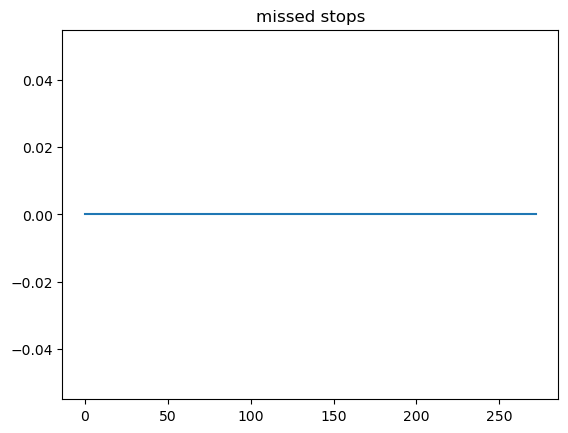

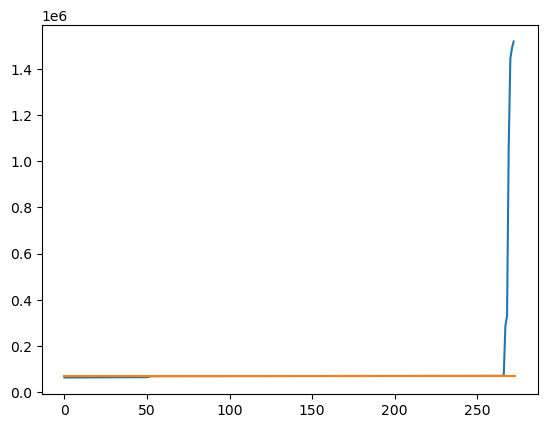

267  eastbound


In [8]:
valid_arts_eb, eb_stops = filter_trips(all_arts_eb)
print(len(valid_arts_eb), f' {directions[0]}bound')

In [9]:
def plot_abq(data, first=True, **kwargs):
    if first:
        print('loading image')
        img = Image.open('abqmap2.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    for row in data:
        if 'latitude' in row:
            plot(row['latitude'], row['longitude'], **kwargs)
        else:
            plot(*row, **kwargs)
def plot(lat,lon,c, **kwargs):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c, **kwargs)

filtering: 100%|█████████████████████████████████████████████████████████████████████| 511/511 [00:05<00:00, 88.10it/s]


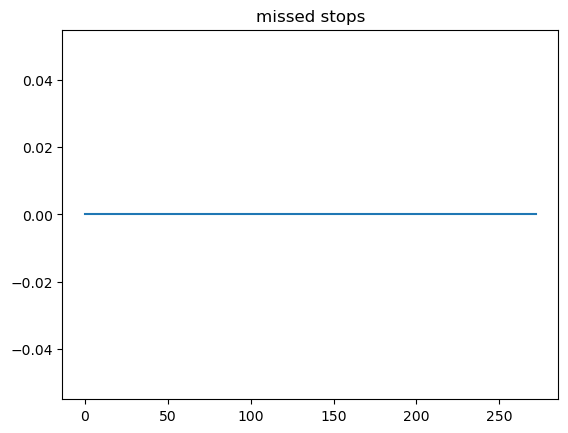

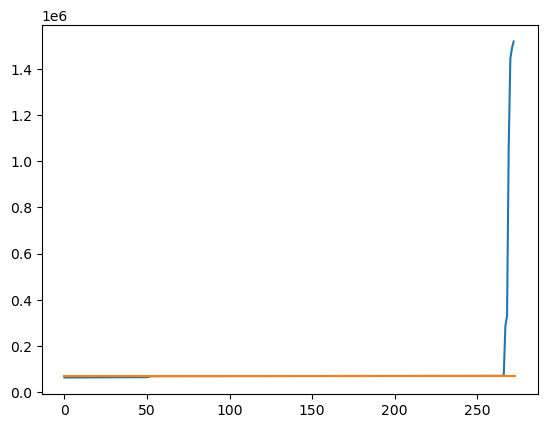

filtering: 100%|████████████████████████████████████████████████████████████████████| 889/889 [00:06<00:00, 133.70it/s]


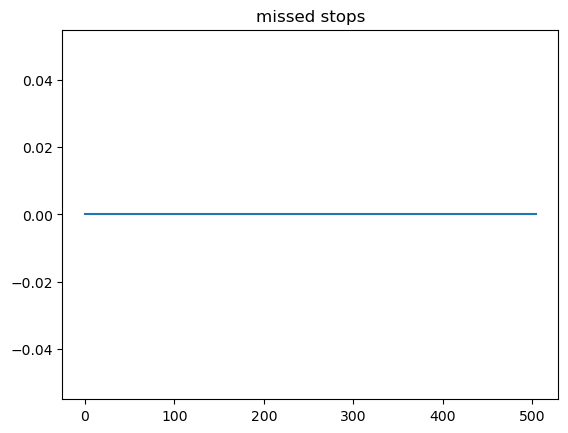

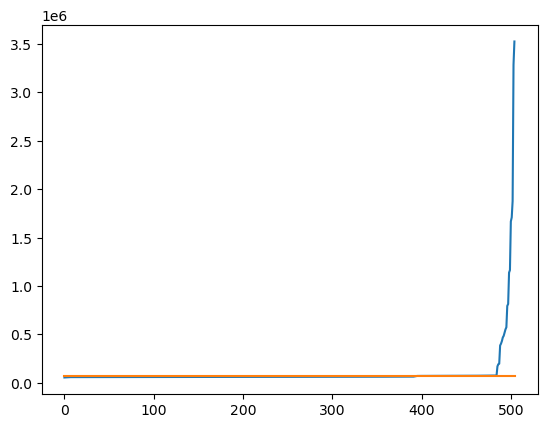

In [10]:
valid_arts_eb, eb_stops = filter_trips(all_arts_eb)
valid_arts_wb, wb_stops = filter_trips(all_arts_wb)

In [16]:
top = -1
for art in valid_arts_wb:
    if max(art.latitude) > top:
        weird_art = art
        top = max(art.latitude)

In [ ]:
plot_abq([{'latitude': lat, 'longitude': lng} for art in valid_arts_wb for i,(lat,lng) in enumerate(zip(art.latitude, art.longitude)) if i %5 == 0], c='blue')

loading image


KeyboardInterrupt: 

In [62]:
lengths = [ sum([np.linalg.norm(ll2euclid(art.latitude.iloc[i], art.longitude.iloc[i]) - ll2euclid(art.latitude.iloc[i-1], art.longitude.iloc[i-1])) for i in range(1,len(art))]) for art in valid_arts_eb]

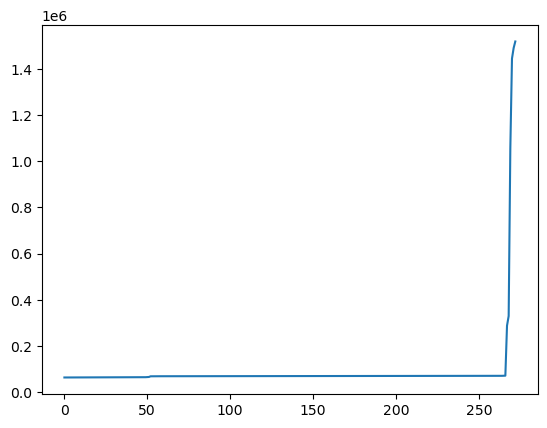

In [64]:
plt.plot(sorted(lengths))

In [14]:
map1 = gis.map("Albuquerque")
map1.basemap = "arcgis-light-gray"
map1.zoom = 12
map1

MapView(layout=Layout(height='400px', width='100%'))

In [17]:
# busstop_points = [ Point({"x": lng, "y": lat, "spatialReference" : {"wkid" : 4326}})  for art in tqdm(valid_arts_eb) for lat,lng in zip(art.latitude, art.longitude)]
busstop_points = [ Point({"x": lng, "y": lat, "spatialReference" : {"wkid" : 4326}})  for lat,lng in zip(weird_art.latitude, weird_art.longitude)]

pt_sym = {
    "type": "esriSMS",
    "style": "esriSMSDiamond",
    "color": [255,140,0,255],        
    "size": 14,
    "angle": 0,
    "xoffset": 0,
    "yoffset": 0,
    "outline": {
        "color": [255,140,0,255],
        "width": 1}
}


In [18]:
for pt in tqdm(busstop_points):
    map1.draw(pt, symbol=pt_sym)

100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 201.94it/s]


In [12]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
import pandas as pd

In [13]:
gis = GIS('home')

In [19]:
map0 = gis.map("Albuquerque")
map0.basemap = "arcgis-light-gray"
map0.zoom = 12
map0

MapView(layout=Layout(height='400px', width='100%'))

In [20]:
busstop_points = [ Point({"x": p['lng'], "y": p['lat'], "spatialReference" : {"wkid" : 4326}}) for p in real_artstop_locations]

pt_sym = {
    "type": "esriSMS",
    "style": "esriSMSDiamond",
    "color": [255,140,0,255],        
    "size": 14,
    "angle": 0,
    "xoffset": 0,
    "yoffset": 0,
    "outline": {
        "color": [255,140,0,255],
        "width": 1}
}


In [21]:
for pt in busstop_points:
    map0.draw(pt, symbol=pt_sym)

In [25]:
df = pd.DataFrame(real_artstop_locations)
df.to_csv("artstops.csv")

In [26]:
all_arts

[        Unnamed: 0  vehicle_id  msg_time   latitude   longitude  heading  \
 279546      279546        1912  09:44:21  35.069620 -106.511345       98   
 279764      279764        1912  09:44:45  35.069039 -106.506012       98   
 279982      279982        1912  09:45:09  35.068490 -106.500953       98   
 280199      280199        1912  09:45:33  35.067897 -106.497852      176   
 280416      280416        1912  09:45:49  35.066352 -106.498129      184   
 ...            ...         ...       ...        ...         ...      ...   
 313400      313400        1912  10:43:49  35.082122 -106.700969      255   
 313617      313617        1912  10:44:13  35.081847 -106.702136      254   
 313834      313834        1912  10:44:37  35.081781 -106.702434      262   
 314051      314051        1912  10:44:53  35.081364 -106.704301      255   
 314269      314269        1912  10:45:17  35.080470 -106.708343      255   
 
         speed_mph route_short_name trip_id next_stop_id  \
 279546       

In [57]:
df1 = pd.concat(valid_arts_eb)
df1.to_csv("valid_arts_eb.csv")

df2 = pd.concat(valid_arts_wb)
df2.to_csv("valid_arts_wb.csv")

# df = pd.concat()

In [28]:
df.to_csv("all_arts.csv")

In [33]:
df

Unnamed: 0  vehicle_id  msg_time   latitude   longitude  heading  \
279546      279546        1912  09:44:21  35.069620 -106.511345     98.0   
279764      279764        1912  09:44:45  35.069039 -106.506012     98.0   
279982      279982        1912  09:45:09  35.068490 -106.500953     98.0   
280199      280199        1912  09:45:33  35.067897 -106.497852    176.0   
280416      280416        1912  09:45:49  35.066352 -106.498129    184.0   
...            ...         ...       ...        ...         ...      ...   
901867      901867        1907  11:56:15  35.078495 -106.725168    347.0   
907734      907734        1907  11:56:15  35.078495 -106.725168    347.0   
907945      907945        1907  11:56:15  35.078495 -106.725168    347.0   
901428      901428        1907  11:56:15  35.078495 -106.725168    347.0   
912722      912722        1907  11:56:15  35.078495 -106.725168    347.0   

        speed_mph route_short_name trip_id next_stop_id  \
279546         43              777  544179    704230162   
279764         47              777  544179    704230162   
279982         35              777  544179    704230162   
280199         18              777  544179    704230162   
280416         12              777  544179    704230162   
...           ...              ...     ...          ...   
901867          0              777  544113    704230895   
907734          0              777  544113    704230895   
907945          0              777  544113    704230895   
901428          0              777  544113    704230895   
912722          0              777  544113    704230895   

                 next_stop_name next_stop_sched_time  \
279546  Tramway @ Wenonah (ART)             09:59:00   
279764  Tramway @ Wenonah (ART)             09:59:00   
279982  Tramway @ Wenonah (ART)             09:59:00   
280199  Tramway @ Wenonah (ART)             09:59:00   
280416  Tramway @ Wenonah (ART)             09:59:00   
...                         ...                  ...   
901867    ART - BioPark Station             11:30:00   
907734    ART - BioPark Station             11:30:00   
907945    ART - BioPark Station             11:30:00   
901428    ART - BioPark Station             11:30:00   
912722    ART - BioPark Station             11:30:00   

                       access_time  
279546  2022-10-11 09:44:32.876628  
279764  2022-10-11 09:44:56.914503  
279982  2022-10-11 09:45:18.012357  
280199  2022-10-11 09:45:40.314795  
280416  2022-10-11 09:46:03.242596  
...                            ...  
901867  2022-09-18 11:57:05.638404  
907734  2022-09-18 12:00:29.461026  
907945  2022-09-18 12:00:41.543516  
901428  2022-09-18 11:56:53.466478  
912722  2022-09-18 12:03:29.750073  

[157259 rows x 13 columns]